In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, concatenate, GRU
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, LSTM, concatenate
from tensorflow.keras.models import Model

In [2]:
pd.set_option('display.max_columns', None) 
df_batters_iso = pd.read_csv('data/df_batters_iso.csv')
df_batters_iso = df_batters_iso.sort_values(by=['game_date', 'player_name', 'release_speed'])
df_batters_iso = df_batters_iso.iloc[-5000000:]
df_batters_iso.drop(['events', 'game_date', 'home_run_hit', 'player_name'], axis=1, inplace=True)
df_batters_iso

,pitch_type,game_year,release_speed,batter,description,stand,type,hit_location,bb_type,balls,strikes,outs_when_up,weight,height,At_Bats,Runs,Hits,Doubles,Triples,HR,RBI,Strikeouts,Intentional_Walks,Hit_by_Pitch,GIDP,Age,Year_Vet,Avg_Hits_PerGame,Avg_HR_PerGame,Avg_Strikeouts_PerGame,Avg_Hit_by_Pitch_PerGame,Avg_Runs_PerGame,Avg_RBI_PerGame,Avg_Grounded_into_DP_PerGame,Avg_Doubles_PerGame,Avg_Triples_PerGame,Singles,Avg_Singles_PerGame,BA,SLG,ISO,home_run_in_game
4661147,ff,2014,96.0,493472,swinging_strike,r,s,0.0,no_hit,1,1,2,215,75,190,16,50,9,0,3,16.0,55.0,0.0,1.0,5.0,27,0,0.588235,0.035294,0.647059,0.011765,0.188235,0.188235,0.058824,0.105882,0.000000,38,0.447059,0.263158,0.357895,0.094737,0
4661146,ff,2014,97.1,493472,foul,r,s,0.0,no_hit,1,2,2,215,75,190,16,50,9,0,3,16.0,55.0,0.0,1.0,5.0,27,0,0.588235,0.035294,0.647059,0.011765,0.188235,0.188235,0.058824,0.105882,0.000000,38,0.447059,0.263158,0.357895,0.094737,0
4839775,si,2014,91.6,572761,hit_into_play,l,x,6.0,ground_ball,1,1,2,210,76,595,99,162,33,2,8,59.0,111.0,2.0,8.0,3.0,29,3,1.025316,0.050633,0.702532,0.050633,0.626582,0.373418,0.018987,0.208861,0.012658,119,0.753165,0.272269,0.374790,0.102521,0
4839777,si,2014,91.6,572761,called_strike,l,s,0.0,no_hit,0,0,2,210,76,595,99,162,33,2,8,59.0,111.0,2.0,8.0,3.0,29,3,1.025316,0.050633,0.702532,0.050633,0.626582,0.373418,0.018987,0.208861,0.012658,119,0.753165,0.272269,0.374790,0.102521,0
4839776,si,2014,92.8,572761,ball,l,b,0.0,no_hit,0,1,2,210,76,595,99,162,33,2,8,59.0,111.0,2.0,8.0,3.0,29,3,1.025316,0.050633,0.702532,0.050633,0.626582,0.373418,0.018987,0.208861,0.012658,119,0.753165,0.272269,0.374790,0.102521,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9638098,ff,2022,96.5,605548,called_strike,l,s,2.0,no_hit,0,2,2,185,74,16,4,4,1,0,0,0.0,4.0,0.0,0.0,0.0,30,5,0.444444,0.000000,0.444444,0.000000,0.444444,0.000000,0.000000,0.111111,0.000000,3,0.333333,0.250000,0.312500,0.062500,0
9638099,ff,2022,96.5,605548,called_strike,l,s,2.0,no_hit,0,2,2,185,74,13,3,1,0,0,0,2.0,8.0,0.0,1.0,0.0,30,5,0.043478,0.000000,0.347826,0.043478,0.130435,0.086957,0.000000,0.000000,0.000000,1,0.043478,0.076923,0.076923,0.000000,0
9638103,ff,2022,96.5,605548,called_strike,l,s,0.0,no_hit,0,0,2,185,74,76,11,8,4,0,2,3.0,33.0,0.0,5.0,0.0,30,5,0.103896,0.025974,0.428571,0.064935,0.142857,0.038961,0.000000,0.051948,0.000000,2,0.025974,0.105263,0.236842,0.131579,0
9638104,ff,2022,96.5,605548,called_strike,l,s,0.0,no_hit,0,0,2,185,74,16,4,4,1,0,0,0.0,4.0,0.0,0.0,0.0,30,5,0.444444,0.000000,0.444444,0.000000,0.444444,0.000000,0.000000,0.111111,0.000000,3,0.333333,0.250000,0.312500,0.062500,0


In [20]:
df_batters_vs_pitchers = pd.read_csv('data/df_batters_vs_pitchers.csv')
df_batters_vs_pitchers = df_batters_vs_pitchers.sort_values(by=['game_date', 'player_name', 'release_speed'])
df_batters_vs_pitchers = df_batters_vs_pitchers.iloc[-5000000:]
df_batters_vs_pitchers.drop(['events', 'game_date', 'home_run_hit', 'player_name', 'home_team', 'away_team', 'home_score', 'away_score'], axis=1, inplace=True)
df_batters_vs_pitchers['description'].replace(['foul_bunt', 'bunt_foul_tip'], 'foul', inplace=True)
df_batters_vs_pitchers['description'].replace(['swinging_strike', 'called_strike', 'swinging_strike_blocked'], 'strike', inplace=True)
df_batters_vs_pitchers['description'].replace(['pitchout', 'swinging_pitchout', 'foul_pitchout'], 'out', inplace=True)
df_batters_vs_pitchers

,pitch_type,game_year,release_speed,batter,description,stand,type,hit_location,bb_type,balls,strikes,outs_when_up,weight,height,At_Bats,Runs,Hits,Doubles,Triples,HR,RBI,Strikeouts,Intentional_Walks,Hit_by_Pitch,GIDP,Age,Year_Vet,Avg_Hits_PerGame,Avg_HR_PerGame,Avg_Strikeouts_PerGame,Avg_Hit_by_Pitch_PerGame,Avg_Runs_PerGame,Avg_RBI_PerGame,Avg_Grounded_into_DP_PerGame,Avg_Doubles_PerGame,Avg_Triples_PerGame,Singles,Avg_Singles_PerGame,BA,SLG,ISO,home_run_in_game,pitcher,p_throws,release_pos_x,release_pos_y,release_pos_z
4875064,ff,2014,91.5,543063,hit_into_play,l,x,9.0,ground_ball,0,0,0,223,73,491,54,121,20,10,10,69.0,129.0,10.0,2.0,4.0,27,3,0.790850,0.065359,0.843137,0.013072,0.352941,0.450980,0.026144,0.130719,0.065359,81,0.529412,0.246436,0.389002,0.142566,0,594986,l,2.59,54.50,5.94
4875059,si,2014,91.6,543063,foul,l,s,0.0,no_hit,1,0,0,223,73,491,54,121,20,10,10,69.0,129.0,10.0,2.0,4.0,27,3,0.790850,0.065359,0.843137,0.013072,0.352941,0.450980,0.026144,0.130719,0.065359,81,0.529412,0.246436,0.389002,0.142566,0,519144,r,-1.81,54.50,5.99
4875060,si,2014,92.3,543063,ball,l,b,0.0,no_hit,0,0,0,223,73,491,54,121,20,10,10,69.0,129.0,10.0,2.0,4.0,27,3,0.790850,0.065359,0.843137,0.013072,0.352941,0.450980,0.026144,0.130719,0.065359,81,0.529412,0.246436,0.389002,0.142566,0,519144,r,-1.78,54.50,6.08
4875063,ff,2014,95.1,543063,ball,l,b,0.0,no_hit,0,0,2,223,73,491,54,121,20,10,10,69.0,129.0,10.0,2.0,4.0,27,3,0.790850,0.065359,0.843137,0.013072,0.352941,0.450980,0.026144,0.130719,0.065359,81,0.529412,0.246436,0.389002,0.142566,0,519175,r,-2.51,54.50,6.03
4875062,ff,2014,96.2,543063,foul,l,s,0.0,no_hit,1,0,2,223,73,491,54,121,20,10,10,69.0,129.0,10.0,2.0,4.0,27,3,0.790850,0.065359,0.843137,0.013072,0.352941,0.450980,0.026144,0.130719,0.065359,81,0.529412,0.246436,0.389002,0.142566,0,519175,r,-2.49,54.50,5.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9716299,ff,2022,96.5,605548,strike,l,s,2.0,no_hit,0,2,2,185,74,16,4,4,1,0,0,0.0,4.0,0.0,0.0,0.0,30,5,0.444444,0.000000,0.444444,0.000000,0.444444,0.000000,0.000000,0.111111,0.000000,3,0.333333,0.250000,0.312500,0.062500,0,657508,r,-1.58,53.90,6.42
9716300,ff,2022,96.5,605548,strike,l,s,2.0,no_hit,0,2,2,185,74,13,3,1,0,0,0,2.0,8.0,0.0,1.0,0.0,30,5,0.043478,0.000000,0.347826,0.043478,0.130435,0.086957,0.000000,0.000000,0.000000,1,0.043478,0.076923,0.076923,0.000000,0,657508,r,-1.58,53.90,6.42
9716304,ff,2022,96.5,605548,strike,l,s,0.0,no_hit,0,0,2,185,74,76,11,8,4,0,2,3.0,33.0,0.0,5.0,0.0,30,5,0.103896,0.025974,0.428571,0.064935,0.142857,0.038961,0.000000,0.051948,0.000000,2,0.025974,0.105263,0.236842,0.131579,0,657508,r,-1.65,53.84,6.38
9716305,ff,2022,96.5,605548,strike,l,s,0.0,no_hit,0,0,2,185,74,16,4,4,1,0,0,0.0,4.0,0.0,0.0,0.0,30,5,0.444444,0.000000,0.444444,0.000000,0.444444,0.000000,0.000000,0.111111,0.000000,3,0.333333,0.250000,0.312500,0.062500,0,657508,r,-1.65,53.84,6.38


In [4]:
df_pitchers_iso = pd.read_csv('pitchers_solo2.csv')
df_pitchers_iso = df_pitchers_iso.sort_values(by=['game_date', 'release_speed'])
df_pitchers_iso = df_pitchers_iso.iloc[-5000000:]
df_pitchers_iso.drop(['events', 'game_date'], axis=1, inplace=True)
df_pitchers_iso

,pitch_type,release_speed,release_pos_x,release_pos_z,pitcher,zone,p_throws,type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,pitch_name,delta_run_exp,weight,height,Age,Year_Vet,Avg_Hits_PerGame,Avg_HR_PerGame,Avg_Walks_PerGame,Avg_Strikeouts_PerGame,Avg_Intent_Walks_PerGame,Avg_Wild_Pitches_PerGame,Avg_Batters_Hit_PerGame,Avg_Batters_Faced_PerSeason,Avg_Runs_Allowed_PerGame
3754826,ff,92.0,1.86,6.75,451085,5.0,l,s,1,0,2014,1.04,1.74,-0.02,2.34,-7.375681,-134.482476,-8.649616,13.748000,28.631000,-9.868000,4-seam fastball,-0.058,190,77,27,5,0.809524,0.111111,0.269841,0.841270,0.063492,0.047619,0.047619,3.587302,0.365079
3807582,ff,92.0,-2.77,6.32,429719,8.0,r,s,1,0,2014,-0.94,1.09,-0.10,1.83,9.136274,-134.569804,-7.243311,-13.000000,28.600000,-17.780000,4-seam fastball,-0.029,215,74,31,11,6.000000,0.642857,2.250000,4.392857,0.107143,0.321429,0.107143,22.607143,3.750000
3817898,ff,92.0,-1.15,6.64,453646,5.0,r,s,3,2,2014,-0.44,1.74,-0.22,2.51,3.479110,-134.765103,-7.913793,-5.940000,30.880000,-10.030000,4-seam fastball,0.000,220,74,31,8,2.119048,0.142857,0.452381,1.714286,0.095238,0.071429,0.071429,8.166667,1.000000
3919026,si,92.0,2.39,6.28,456034,6.0,l,s,0,1,2014,1.44,1.47,0.37,2.70,-8.782604,-134.670367,-5.840234,18.832000,29.678000,-13.619000,sinker,-0.046,215,77,29,6,6.727273,0.454545,1.363636,7.454545,0.000000,0.000000,0.000000,29.090909,2.909091
3919027,si,92.0,2.39,6.28,456034,6.0,l,s,0,1,2014,1.44,1.47,0.37,2.70,-8.782604,-134.670367,-5.840234,18.832000,29.678000,-13.619000,sinker,-0.046,215,77,29,6,6.782609,0.869565,1.000000,8.217391,0.043478,0.086957,0.217391,29.956522,2.956522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8903918,si,98.9,-1.70,5.29,628708,4.0,r,s,1,2,2022,-1.53,0.44,-0.39,2.06,7.127029,-143.798131,-4.404334,-22.871716,33.389474,-25.292384,sinker,0.000,180,74,27,0,1.205128,0.128205,0.564103,1.128205,0.000000,0.076923,0.153846,5.487179,0.820513
8921211,si,98.9,-1.62,6.17,663855,11.0,r,b,1,1,2022,-1.40,0.68,-0.64,3.52,5.984968,-143.925798,-3.421113,-20.918728,30.783344,-22.163114,sinker,0.029,220,74,26,4,1.314286,0.142857,1.000000,1.800000,0.000000,0.142857,0.200000,7.514286,0.942857
8486944,fc,99.0,-0.90,6.38,668933,14.0,r,b,0,1,2022,0.10,0.74,1.54,2.22,6.322273,-143.980351,-7.551036,-0.098572,34.108280,-20.278658,cutter,0.016,248,74,24,0,6.263158,0.578947,1.578947,3.736842,0.052632,0.473684,0.421053,24.421053,3.210526
8486953,fc,99.0,-1.09,6.28,668933,5.0,r,s,2,0,2022,-0.36,0.95,-0.07,2.46,3.598509,-144.030349,-7.134993,-5.892479,32.533653,-17.575589,cutter,-0.042,248,74,24,0,6.263158,0.578947,1.578947,3.736842,0.052632,0.473684,0.421053,24.421053,3.210526


In [19]:
pitchers_vs_batters = pd.read_csv('pitchers_vs_batters.csv')
pitchers_vs_batters = pitchers_vs_batters.sort_values(by=['game_date', 'release_speed'])
pitchers_vs_batters = pitchers_vs_batters.iloc[-5000000:]
pitchers_vs_batters.drop(['events', 'game_date', 'home_score', 'away_score'], axis=1, inplace=True)
pitchers_vs_batters

,pitch_type,release_speed,release_pos_x,release_pos_z,pitcher,zone,p_throws,type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,pitch_name,delta_run_exp,weight,height,Age,Year_Vet,Avg_Hits_PerGame,Avg_HR_PerGame,Avg_Walks_PerGame,Avg_Strikeouts_PerGame,Avg_Intent_Walks_PerGame,Avg_Wild_Pitches_PerGame,Avg_Batters_Hit_PerGame,Avg_Batters_Faced_PerSeason,Avg_Runs_Allowed_PerGame,batter,stand,sz_top,sz_bot,fielder_2
4334984,ch,83.9,-2.29,6.69,519344,13.0,r,b,1,1,2014,-0.08,0.39,-0.31,0.78,4.755375,-122.559100,-7.044817,-1.531000,19.013000,-27.244000,changeup,0.047,240,76,26,1,5.565217,0.652174,1.913043,2.434783,0.086957,0.043478,0.304348,23.347826,2.869565,425545,r,3.21,1.51,460269
3752897,sl,84.0,-2.68,5.46,527054,9.0,r,s,1,1,2014,0.23,0.54,0.49,1.83,6.833877,-122.902231,-2.082180,0.956000,22.734000,-26.479000,slider,-0.034,205,74,23,3,5.696970,0.666667,1.545455,5.636364,0.121212,0.030303,0.121212,26.787879,2.484848,407781,r,3.39,1.58,408042
3816645,fc,84.0,-2.28,6.55,519443,12.0,r,s,0,0,2014,0.56,0.28,0.12,3.26,4.254528,-122.997435,-0.704409,4.780000,22.540000,-29.300000,cutter,-0.031,235,77,26,1,4.631579,0.578947,1.894737,3.684211,0.000000,0.105263,0.052632,19.894737,3.000000,458731,l,2.95,1.40,150229
3938212,sl,84.0,1.12,6.46,554431,11.0,l,x,0,1,2014,-0.28,-0.40,-1.34,2.89,-5.065651,-123.105673,0.248559,-1.754000,24.305000,-36.159000,slider,-0.242,230,75,24,0,6.000000,0.450000,2.200000,4.550000,0.050000,0.150000,0.150000,25.150000,2.650000,460576,r,3.62,1.64,502374
3981152,sl,84.0,-1.98,6.74,434378,3.0,r,s,0,0,2014,0.83,0.79,0.34,2.94,3.423221,-123.036896,-3.100719,7.624000,22.424000,-23.797000,slider,-0.031,235,77,31,9,6.968750,0.562500,2.031250,4.968750,0.031250,0.156250,0.156250,27.906250,3.562500,514888,r,2.96,1.34,488671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8951242,si,98.9,-1.70,5.29,628708,4.0,r,s,1,2,2022,-1.53,0.44,-0.39,2.06,7.127029,-143.798131,-4.404334,-22.871716,33.389474,-25.292384,sinker,0.000,180,74,27,0,1.205128,0.128205,0.564103,1.128205,0.000000,0.076923,0.153846,5.487179,0.820513,571976,r,3.25,1.44,663698
8968551,si,98.9,-1.62,6.17,663855,11.0,r,b,1,1,2022,-1.40,0.68,-0.64,3.52,5.984968,-143.925798,-3.421113,-20.918728,30.783344,-22.163114,sinker,0.029,220,74,26,4,1.314286,0.142857,1.000000,1.800000,0.000000,0.142857,0.200000,7.514286,0.942857,678225,l,2.94,1.35,668800
8533855,fc,99.0,-0.90,6.38,668933,14.0,r,b,0,1,2022,0.10,0.74,1.54,2.22,6.322273,-143.980351,-7.551036,-0.098572,34.108280,-20.278658,cutter,0.016,248,74,24,0,6.263158,0.578947,1.578947,3.736842,0.052632,0.473684,0.421053,24.421053,3.210526,614177,r,3.91,1.83,519222
8533864,fc,99.0,-1.09,6.28,668933,5.0,r,s,2,0,2022,-0.36,0.95,-0.07,2.46,3.598509,-144.030349,-7.134993,-5.892479,32.533653,-17.575589,cutter,-0.042,248,74,24,0,6.263158,0.578947,1.578947,3.736842,0.052632,0.473684,0.421053,24.421053,3.210526,673548,r,3.07,1.41,519222


## Encoding

In [6]:
categorical_cols = ['pitch_type', 'description', 'stand', 'type', 'bb_type']
df_batters_iso_encoded = pd.get_dummies(df_batters_iso, columns=categorical_cols, drop_first=True)
df_batters_iso_encoded

,game_year,release_speed,batter,hit_location,balls,strikes,outs_when_up,weight,height,At_Bats,Runs,Hits,Doubles,Triples,HR,RBI,Strikeouts,Intentional_Walks,Hit_by_Pitch,GIDP,Age,Year_Vet,Avg_Hits_PerGame,Avg_HR_PerGame,Avg_Strikeouts_PerGame,Avg_Hit_by_Pitch_PerGame,Avg_Runs_PerGame,Avg_RBI_PerGame,Avg_Grounded_into_DP_PerGame,Avg_Doubles_PerGame,Avg_Triples_PerGame,Singles,Avg_Singles_PerGame,BA,SLG,ISO,home_run_in_game,pitch_type_ch,pitch_type_cs,pitch_type_cu,pitch_type_ep,pitch_type_fa,pitch_type_fc,pitch_type_ff,pitch_type_fo,pitch_type_fs,pitch_type_in,pitch_type_kc,pitch_type_kn,pitch_type_po,pitch_type_sc,pitch_type_si,pitch_type_sl,pitch_type_st,pitch_type_sv,description_blocked_ball,description_bunt_foul_tip,description_called_strike,description_foul,description_foul_bunt,description_foul_pitchout,description_foul_tip,description_hit_by_pitch,description_hit_into_play,description_intent_ball,description_missed_bunt,description_pitchout,description_swinging_pitchout,description_swinging_strike,description_swinging_strike_blocked,stand_r,type_s,type_x,bb_type_ground_ball,bb_type_line_drive,bb_type_no_hit,bb_type_popup
4661147,2014,96.0,493472,0.0,1,1,2,215,75,190,16,50,9,0,3,16.0,55.0,0.0,1.0,5.0,27,0,0.588235,0.035294,0.647059,0.011765,0.188235,0.188235,0.058824,0.105882,0.000000,38,0.447059,0.263158,0.357895,0.094737,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0
4661146,2014,97.1,493472,0.0,1,2,2,215,75,190,16,50,9,0,3,16.0,55.0,0.0,1.0,5.0,27,0,0.588235,0.035294,0.647059,0.011765,0.188235,0.188235,0.058824,0.105882,0.000000,38,0.447059,0.263158,0.357895,0.094737,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
4839775,2014,91.6,572761,6.0,1,1,2,210,76,595,99,162,33,2,8,59.0,111.0,2.0,8.0,3.0,29,3,1.025316,0.050633,0.702532,0.050633,0.626582,0.373418,0.018987,0.208861,0.012658,119,0.753165,0.272269,0.374790,0.102521,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0
4839777,2014,91.6,572761,0.0,0,0,2,210,76,595,99,162,33,2,8,59.0,111.0,2.0,8.0,3.0,29,3,1.025316,0.050633,0.702532,0.050633,0.626582,0.373418,0.018987,0.208861,0.012658,119,0.753165,0.272269,0.374790,0.102521,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4839776,2014,92.8,572761,0.0,0,1,2,210,76,595,99,162,33,2,8,59.0,111.0,2.0,8.0,3.0,29,3,1.025316,0.050633,0.702532,0.050633,0.626582,0.373418,0.018987,0.208861,0.012658,119,0.753165,0.272269,0.374790,0.102521,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9638098,2022,96.5,605548,2.0,0,2,2,185,74,16,4,4,1,0,0,0.0,4.0,0.0,0.0,0.0,30,5,0.444444,0.000000,0.444444,0.000000,0.444444,0.000000,0.000000,0.111111,0.000000,3,0.333333,0.250000,0.312500,0.062500,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
9638099,2022,96.5,605548,2.0,0,2,2,185,74,13,3,1,0,0,0,2.0,8.0,0.0,1.0,0.0,30,5,0.043478,0.000000,0.347826,0.043478,0.130435,0.086957,0.000000,0.000000,0.000000,1,0.043478,0.076923,0.076923,0.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
9638103,2022,96.5,605548,0.0,0,0,2,185,74,76,11,8,4,0,2,3.0,33.0,0.0,5.0,0.0,30,5,0.103896,0.025974,0.428571,0.064935,0.142857,0.038961,0.000000,0.051948,0.000000,2,0.025974,0.105263,0.236842,0.131579,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
9638104,2022,96.5,605548,0.0,0,0,2,185,74,16,4,4,1,0,0,0.0,4.0,0.0,0.0,0.0,30,5,0.444444,0.000000,0.444444,0.000000,0.444444,0.000000,0.000000,0.111111,0.000000,3,0.333333,0.250000,0.312500,0.062500,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0

In [7]:
categorical_cols = ['pitch_type', 'description', 'stand', 'type', 'bb_type', 'p_throws']
df_batters_vs_pitchers_encoded = pd.get_dummies(df_batters_vs_pitchers, columns=categorical_cols, drop_first=True)
df_batters_vs_pitchers_encoded

,game_year,release_speed,batter,hit_location,balls,strikes,outs_when_up,weight,height,At_Bats,Runs,Hits,Doubles,Triples,HR,RBI,Strikeouts,Intentional_Walks,Hit_by_Pitch,GIDP,Age,Year_Vet,Avg_Hits_PerGame,Avg_HR_PerGame,Avg_Strikeouts_PerGame,Avg_Hit_by_Pitch_PerGame,Avg_Runs_PerGame,Avg_RBI_PerGame,Avg_Grounded_into_DP_PerGame,Avg_Doubles_PerGame,Avg_Triples_PerGame,Singles,Avg_Singles_PerGame,BA,SLG,ISO,home_run_in_game,pitcher,release_pos_x,release_pos_y,release_pos_z,home_score,away_score,pitch_type_ch,pitch_type_cs,pitch_type_cu,pitch_type_ep,pitch_type_fa,pitch_type_fc,pitch_type_ff,pitch_type_fo,pitch_type_fs,pitch_type_in,pitch_type_kc,pitch_type_kn,pitch_type_po,pitch_type_sc,pitch_type_si,pitch_type_sl,pitch_type_st,pitch_type_sv,description_blocked_ball,description_foul,description_foul_tip,description_hit_by_pitch,description_hit_into_play,description_intent_ball,description_missed_bunt,description_out,description_strike,stand_r,type_s,type_x,bb_type_ground_ball,bb_type_line_drive,bb_type_no_hit,bb_type_popup,p_throws_r
4875064,2014,91.5,543063,9.0,0,0,0,223,73,491,54,121,20,10,10,69.0,129.0,10.0,2.0,4.0,27,3,0.790850,0.065359,0.843137,0.013072,0.352941,0.450980,0.026144,0.130719,0.065359,81,0.529412,0.246436,0.389002,0.142566,0,594986,2.59,54.50,5.94,2,8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
4875059,2014,91.6,543063,0.0,1,0,0,223,73,491,54,121,20,10,10,69.0,129.0,10.0,2.0,4.0,27,3,0.790850,0.065359,0.843137,0.013072,0.352941,0.450980,0.026144,0.130719,0.065359,81,0.529412,0.246436,0.389002,0.142566,0,519144,-1.81,54.50,5.99,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
4875060,2014,92.3,543063,0.0,0,0,0,223,73,491,54,121,20,10,10,69.0,129.0,10.0,2.0,4.0,27,3,0.790850,0.065359,0.843137,0.013072,0.352941,0.450980,0.026144,0.130719,0.065359,81,0.529412,0.246436,0.389002,0.142566,0,519144,-1.78,54.50,6.08,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4875063,2014,95.1,543063,0.0,0,0,2,223,73,491,54,121,20,10,10,69.0,129.0,10.0,2.0,4.0,27,3,0.790850,0.065359,0.843137,0.013072,0.352941,0.450980,0.026144,0.130719,0.065359,81,0.529412,0.246436,0.389002,0.142566,0,519175,-2.51,54.50,6.03,0,7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4875062,2014,96.2,543063,0.0,1,0,2,223,73,491,54,121,20,10,10,69.0,129.0,10.0,2.0,4.0,27,3,0.790850,0.065359,0.843137,0.013072,0.352941,0.450980,0.026144,0.130719,0.065359,81,0.529412,0.246436,0.389002,0.142566,0,519175,-2.49,54.50,5.96,0,7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9716299,2022,96.5,605548,2.0,0,2,2,185,74,16,4,4,1,0,0,0.0,4.0,0.0,0.0,0.0,30,5,0.444444,0.000000,0.444444,0.000000,0.444444,0.000000,0.000000,0.111111,0.000000,3,0.333333,0.250000,0.312500,0.062500,0,657508,-1.58,53.90,6.42,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1
9716300,2022,96.5,605548,2.0,0,2,2,185,74,13,3,1,0,0,0,2.0,8.0,0.0,1.0,0.0,30,5,0.043478,0.000000,0.347826,0.043478,0.130435,0.086957,0.000000,0.000000,0.000000,1,0.043478,0.076923,0.076923,0.000000,0,657508,-1.58,53.90,6.42,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1
9716304,2022,96.5,605548,0.0,0,0,2,185,74,76,11,8,4,0,2,3.0,33.0,0.0,5.0,0.0,30,5,0.103896,0.025974,0.428571,0.064935,0.142857,0.038961,0.000000,0.051948,0.000000,2,0.025974,0.105263,0.236842,0.131579,0,657508,-1.65,53.84,6.38,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1
9716305,2022,96.5,605548,0.0,0,0,2,185,74,16,4,4,1,0,0,0.0,4.0,0.0,0.0,0.0,30,5,0.444444,0.000000,0.444444,0.000000,0.444444,0.000000,0.000000,0.111111,0.000000,3,0.333333,0.250000,0.3

In [8]:
categorical_cols = ['pitch_type', 'p_throws', 'type', 'pitch_name']
df_pitchers_iso_encoded = pd.get_dummies(df_pitchers_iso, columns=categorical_cols, drop_first=True)
df_pitchers_iso_encoded

,release_speed,release_pos_x,release_pos_z,pitcher,zone,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,delta_run_exp,weight,height,Age,Year_Vet,Avg_Hits_PerGame,Avg_HR_PerGame,Avg_Walks_PerGame,Avg_Strikeouts_PerGame,Avg_Intent_Walks_PerGame,Avg_Wild_Pitches_PerGame,Avg_Batters_Hit_PerGame,Avg_Batters_Faced_PerSeason,Avg_Runs_Allowed_PerGame,pitch_type_ch,pitch_type_cs,pitch_type_cu,pitch_type_ep,pitch_type_fa,pitch_type_fc,pitch_type_ff,pitch_type_fo,pitch_type_fs,pitch_type_kc,pitch_type_kn,pitch_type_po,pitch_type_sc,pitch_type_si,pitch_type_sl,pitch_type_st,pitch_type_sv,p_throws_r,type_s,type_x,pitch_name_automatic ball,pitch_name_changeup,pitch_name_curveball,pitch_name_cutter,pitch_name_eephus,pitch_name_forkball,pitch_name_knuckle curve,pitch_name_knuckleball,pitch_name_other,pitch_name_pitch out,pitch_name_screwball,pitch_name_sinker,pitch_name_slider,pitch_name_slow curve,pitch_name_slurve,pitch_name_split-finger,pitch_name_sweeper
3754826,92.0,1.86,6.75,451085,5.0,1,0,2014,1.04,1.74,-0.02,2.34,-7.375681,-134.482476,-8.649616,13.748000,28.631000,-9.868000,-0.058,190,77,27,5,0.809524,0.111111,0.269841,0.841270,0.063492,0.047619,0.047619,3.587302,0.365079,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3807582,92.0,-2.77,6.32,429719,8.0,1,0,2014,-0.94,1.09,-0.10,1.83,9.136274,-134.569804,-7.243311,-13.000000,28.600000,-17.780000,-0.029,215,74,31,11,6.000000,0.642857,2.250000,4.392857,0.107143,0.321429,0.107143,22.607143,3.750000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3817898,92.0,-1.15,6.64,453646,5.0,3,2,2014,-0.44,1.74,-0.22,2.51,3.479110,-134.765103,-7.913793,-5.940000,30.880000,-10.030000,0.000,220,74,31,8,2.119048,0.142857,0.452381,1.714286,0.095238,0.071429,0.071429,8.166667,1.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3919026,92.0,2.39,6.28,456034,6.0,0,1,2014,1.44,1.47,0.37,2.70,-8.782604,-134.670367,-5.840234,18.832000,29.678000,-13.619000,-0.046,215,77,29,6,6.727273,0.454545,1.363636,7.454545,0.000000,0.000000,0.000000,29.090909,2.909091,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3919027,92.0,2.39,6.28,456034,6.0,0,1,2014,1.44,1.47,0.37,2.70,-8.782604,-134.670367,-5.840234,18.832000,29.678000,-13.619000,-0.046,215,77,29,6,6.782609,0.869565,1.000000,8.217391,0.043478,0.086957,0.217391,29.956522,2.956522,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8903918,98.9,-1.70,5.29,628708,4.0,1,2,2022,-1.53,0.44,-0.39,2.06,7.127029,-143.798131,-4.404334,-22.871716,33.389474,-25.292384,0.000,180,74,27,0,1.205128,0.128205,0.564103,1.128205,0.000000,0.076923,0.153846,5.487179,0.820513,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8921211,98.9,-1.62,6.17,663855,11.0,1,1,2022,-1.40,0.68,-0.64,3.52,5.984968,-143.925798,-3.421113,-20.918728,30.783344,-22.163114,0.029,220,74,26,4,1.314286,0.142857,1.000000,1.800000,0.000000,0.142857,0.200000,7.514286,0.942857,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8486944,99.0,-0.90,6.38,668933,14.0,0,1,2022,0.10,0.74,1.54,2.22,6.322273,-143.980351,-7.551036,-0.098572,34.108280,-20.278658,0.016,248,74,24,0,6.263158,0.578947,1.578947,3.736842,0.052632,0.473684,0.421053,24.421053,3.210526,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8486953,99.0,-1.09,6.28,668933,5.0,2,0,2022,-0.36,0.95,-0.07,2.46,3.598509,-144.030349,-7.134993,-5.892479,32.533653,-17.575589,-0.042,248,74,24,0,6.263158,0.578947,1.578947,3.736842,0.052632,0.473684,0.421053,24.421053,3.210526,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
categorical_cols = ['pitch_type', 'p_throws', 'type', 'pitch_name', 'stand']
pitchers_vs_batters_encoded = pd.get_dummies(pitchers_vs_batters, columns=categorical_cols, drop_first=True)
pitchers_vs_batters_encoded

,release_speed,release_pos_x,release_pos_z,pitcher,zone,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,delta_run_exp,weight,height,Age,Year_Vet,Avg_Hits_PerGame,Avg_HR_PerGame,Avg_Walks_PerGame,Avg_Strikeouts_PerGame,Avg_Intent_Walks_PerGame,Avg_Wild_Pitches_PerGame,Avg_Batters_Hit_PerGame,Avg_Batters_Faced_PerSeason,Avg_Runs_Allowed_PerGame,batter,sz_top,sz_bot,home_score,away_score,fielder_2,pitch_type_ch,pitch_type_cs,pitch_type_cu,pitch_type_ep,pitch_type_fa,pitch_type_fc,pitch_type_ff,pitch_type_fo,pitch_type_fs,pitch_type_kc,pitch_type_kn,pitch_type_po,pitch_type_sc,pitch_type_si,pitch_type_sl,pitch_type_st,pitch_type_sv,p_throws_r,type_s,type_x,pitch_name_automatic ball,pitch_name_changeup,pitch_name_curveball,pitch_name_cutter,pitch_name_eephus,pitch_name_forkball,pitch_name_knuckle curve,pitch_name_knuckleball,pitch_name_other,pitch_name_pitch out,pitch_name_screwball,pitch_name_sinker,pitch_name_slider,pitch_name_slow curve,pitch_name_slurve,pitch_name_split-finger,pitch_name_sweeper,stand_r
4334984,83.9,-2.29,6.69,519344,13.0,1,1,2014,-0.08,0.39,-0.31,0.78,4.755375,-122.559100,-7.044817,-1.531000,19.013000,-27.244000,0.047,240,76,26,1,5.565217,0.652174,1.913043,2.434783,0.086957,0.043478,0.304348,23.347826,2.869565,425545,3.21,1.51,2,0,460269,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3752897,84.0,-2.68,5.46,527054,9.0,1,1,2014,0.23,0.54,0.49,1.83,6.833877,-122.902231,-2.082180,0.956000,22.734000,-26.479000,-0.034,205,74,23,3,5.696970,0.666667,1.545455,5.636364,0.121212,0.030303,0.121212,26.787879,2.484848,407781,3.39,1.58,0,4,408042,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3816645,84.0,-2.28,6.55,519443,12.0,0,0,2014,0.56,0.28,0.12,3.26,4.254528,-122.997435,-0.704409,4.780000,22.540000,-29.300000,-0.031,235,77,26,1,4.631579,0.578947,1.894737,3.684211,0.000000,0.105263,0.052632,19.894737,3.000000,458731,2.95,1.40,4,0,150229,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3938212,84.0,1.12,6.46,554431,11.0,0,1,2014,-0.28,-0.40,-1.34,2.89,-5.065651,-123.105673,0.248559,-1.754000,24.305000,-36.159000,-0.242,230,75,24,0,6.000000,0.450000,2.200000,4.550000,0.050000,0.150000,0.150000,25.150000,2.650000,460576,3.62,1.64,0,0,502374,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3981152,84.0,-1.98,6.74,434378,3.0,0,0,2014,0.83,0.79,0.34,2.94,3.423221,-123.036896,-3.100719,7.624000,22.424000,-23.797000,-0.031,235,77,31,9,6.968750,0.562500,2.031250,4.968750,0.031250,0.156250,0.156250,27.906250,3.562500,514888,2.96,1.34,1,1,488671,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8951242,98.9,-1.70,5.29,628708,4.0,1,2,2022,-1.53,0.44,-0.39,2.06,7.127029,-143.798131,-4.404334,-22.871716,33.389474,-25.292384,0.000,180,74,27,0,1.205128,0.128205,0.564103,1.128205,0.000000,0.076923,0.153846,5.487179,0.820513,571976,3.25,1.44,1,0,663698,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
8968551,98.9,-1.62,6.17,663855,11.0,1,1,2022,-1.40,0.68,-0.64,3.52,5.984968,-143.925798,-3.421113,-20.918728,30.783344,-22.163114,0.029,220,74,26,4,1.314286,0.142857,1.000000,1.800000,0.000000,0.142857,0.200000,7.514286,0.942857,678225,2.94,1.35,5,3,668800,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8533855,99.0,-0.90,6.38,668933,14.0,0,1,2022,0.10,0.74,1.54,2.22,6.322273,-143.980351,-7.551036,-0.098572,34.108280,-20.278658,0.016,248,74,24,0,6.263158,0.578947,1.578947,3.736842,0.052632,0.473684,0.421053,24.421053,3.210526,614177,3.91,1.83,0,0,519222,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0

In [10]:
del df_batters_iso
del df_batters_vs_pitchers
del df_pitchers_iso
del pitchers_vs_batters

In [11]:
# List of dataframes
dfs = [df_batters_iso_encoded, df_batters_vs_pitchers_encoded, df_pitchers_iso_encoded, pitchers_vs_batters_encoded]

scaled_data = []

# Process each dataframe
for df in dfs:
    # If the dataframe is one of the batter dataframes
    if 'home_run_in_game' in df.columns:
        X = df.drop('home_run_in_game', axis=1)
        y = df['home_run_in_game']

        # Split the data into training, validation, and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

        # Apply scaling
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        # Append the processed data to the list
        scaled_data.append((X_train, X_val, X_test, y_train, y_val, y_test))

    # If the dataframe is one of the pitcher dataframes
    else:
        X = df

        # Split the data into training, validation, and testing sets
        X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)
        X_val, X_test = train_test_split(X_test, test_size=0.5, random_state=42)

        # Apply scaling
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        # Append the processed data to the list
        scaled_data.append((X_train, X_val, X_test))


In [12]:
(X_train_batters_iso, X_val_batters_iso, _, y_train_batters_iso, y_val_batters_iso, _), \
(X_train_batters_vs_pitchers, X_val_batters_vs_pitchers, _, y_train_batters_vs_pitchers, y_val_batters_vs_pitchers, _), \
(X_train_pitchers_iso, X_val_pitchers_iso, _), \
(X_train_pitchers_vs_batters, X_val_pitchers_vs_batters, _) = scaled_data

In [13]:
input_batters_iso = Input(shape=(X_train_batters_iso.shape[1],))
input_batters_vs_pitchers = Input(shape=(X_train_batters_vs_pitchers.shape[1],))
input_pitchers_iso = Input(shape=(X_train_pitchers_iso.shape[1],))
input_pitchers_vs_batters = Input(shape=(X_train_pitchers_vs_batters.shape[1],))

dense_batters_iso = Dense(32, activation='tanh')(input_batters_iso)
dense_batters_iso = Dense(64, activation='tanh')(dense_batters_iso)

dense_batters_vs_pitchers = Dense(32, activation='tanh')(input_batters_vs_pitchers)
dense_batters_vs_pitchers = Dense(64, activation='tanh')(dense_batters_vs_pitchers)

dense_pitchers_iso = Dense(32, activation='tanh')(input_pitchers_iso)
dense_pitchers_iso = Dense(64, activation='tanh')(dense_pitchers_iso)

dense_pitchers_vs_batters = Dense(32, activation='tanh')(input_pitchers_vs_batters)
dense_pitchers_vs_batters = Dense(64, activation='tanh')(dense_pitchers_vs_batters)

# Concatenate the outputs of the Dense layers
concat = concatenate([dense_batters_iso, dense_batters_vs_pitchers, dense_pitchers_iso, dense_pitchers_vs_batters])

# Add more dense layers as needed
dense_hidden = Dense(128, activation='tanh')(concat)
dense_hidden = Dense(64, activation='tanh')(dense_hidden)

# Add a Dense layer for the final prediction
output = Dense(1, activation='sigmoid')(dense_hidden)

model = Model(inputs=[input_batters_iso, input_batters_vs_pitchers, input_pitchers_iso, input_pitchers_vs_batters], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    [X_train_batters_iso, X_train_batters_vs_pitchers, X_train_pitchers_iso, X_train_pitchers_vs_batters], 
    y_train_batters_iso, 
    epochs=50, batch_size=32, 
    validation_data=([X_val_batters_iso, X_val_batters_vs_pitchers, X_val_pitchers_iso, X_val_pitchers_vs_batters], y_val_batters_iso),
    callbacks=[early_stopping])

Epoch 1/50
109375/109375 [==============================] - 80s 736us/step - loss: 0.3386 - accuracy: 0.8851 - val_loss: 0.3376 - val_accuracy: 0.8853
Epoch 2/50
109375/109375 [==============================] - 78s 717us/step - loss: 0.3374 - accuracy: 0.8854 - val_loss: 0.3369 - val_accuracy: 0.8854
Epoch 3/50
109375/109375 [==============================] - 78s 714us/step - loss: 0.3373 - accuracy: 0.8855 - val_loss: 0.3371 - val_accuracy: 0.8855
Epoch 4/50
109375/109375 [==============================] - 80s 734us/step - loss: 0.3376 - accuracy: 0.8855 - val_loss: 0.3376 - val_accuracy: 0.8855
Epoch 5/50
109375/109375 [==============================] - 79s 726us/step - loss: 0.3380 - accuracy: 0.8855 - val_loss: 0.3382 - val_accuracy: 0.8855


In [16]:
# Make predictions on the validation set
y_val_pred = model.predict([X_val_batters_iso, X_val_batters_vs_pitchers, X_val_pitchers_iso, X_val_pitchers_vs_batters])

# Compute binary predictions
y_val_pred_bin = (y_val_pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_val_batters_iso, y_val_pred_bin))

print("ROC AUC score:")
print(roc_auc_score(y_val_batters_iso, y_val_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94    658390
           1       0.93      0.07      0.12     91610

    accuracy                           0.89    750000
   macro avg       0.91      0.53      0.53    750000
weighted avg       0.89      0.89      0.84    750000

ROC AUC score:
0.6911567737243491


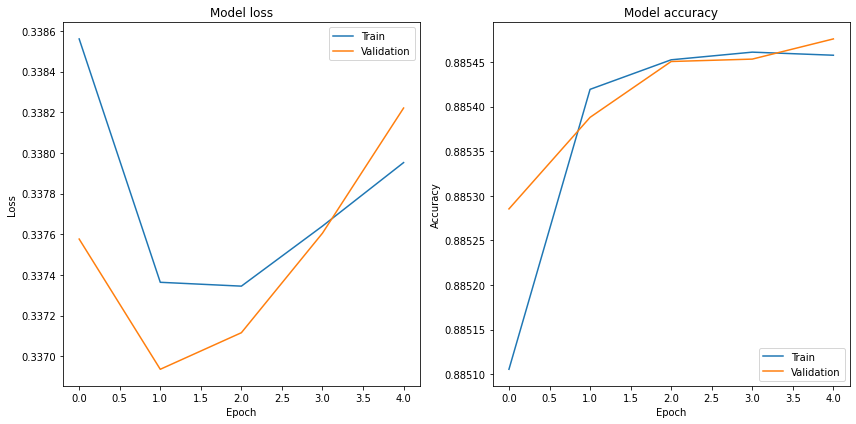

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()


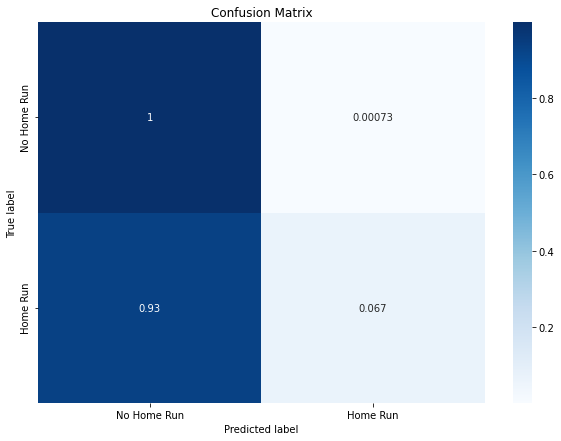

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_val_batters_iso, y_val_pred_bin)

# Normalize the confusion matrix (so that each row sums to 1)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the confusion matrix for easier plotting
cm_df = pd.DataFrame(cm_norm, index = ['No Home Run', 'Home Run'], columns = ['No Home Run', 'Home Run'])

plt.figure(figsize=(10, 7))

# Create a heatmap from the DataFrame
sns.heatmap(cm_df, annot=True, cmap='Blues')

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [21]:
from imblearn.over_sampling import SMOTE

# Define SMOTE instance
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data (note that SMOTE should only be applied to the training data)
X_train_batters_iso_sm, y_train_batters_iso_sm = smote.fit_resample(X_train_batters_iso, y_train_batters_iso)
X_train_batters_vs_pitchers_sm, y_train_batters_vs_pitchers_sm = smote.fit_resample(X_train_batters_vs_pitchers, y_train_batters_vs_pitchers)


In [ ]:
history = model.fit(
    [X_train_batters_iso_sm, X_train_batters_vs_pitchers_sm, X_train_pitchers_iso, X_train_pitchers_vs_batters], 
    y_train_batters_iso_sm, 
    epochs=50, batch_size=32, 
    validation_data=([X_val_batters_iso, X_val_batters_vs_pitchers, X_val_pitchers_iso, X_val_pitchers_vs_batters], y_val_batters_iso),
    callbacks=[early_stopping])
